# Reproducing L4A AGBD estimates from GEDI L2A RH metrics 
This tutorial shows how to reconstruct L4A aboveground biomass density (AGBD) estimates {cite}`dubayah2022` using L2A relative height (RH) metrics {cite}`dubayah2021c`. We will use a GEDI L4A file `GEDI04_A_2020207182449_O09168_03_T03028_02_002_02_V002.h5` and corresponding GEDI L2A file `GEDI02_A_2020207182449_O09168_03_T03028_02_003_01_V002.h5` from the orbit `09168` and track `03028` for this purpose.

```{admonition} Learning Objectives
- Reconstruct L4A AGBD value for a single shot
- Apply for all the shots within a single L2A beam to reconstruct AGBD value
```

## Requirements
Additional prerequisites are provided [here](../docs/prerequisites). 

In [1]:
# import all the modules
from os import path
import earthaccess
import h5py
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

We will use `earthaccess` module to authenticate to [NASA Earthdata Login](https://urs.earthdata.nasa.gov) and download the GEDI L2A and L4A files to the `full_orbits` directory.

In [2]:
# authenticate using the EDL login
try:
    auth = earthaccess.login(strategy="netrc")
except FileNotFoundError:
    auth = earthaccess.login(strategy="interactive", persist=True)

def search_download(doi):
    """searches and downloads GEDI granules"""
    granules = earthaccess.search_data(doi=doi,
                                       granule_name=f"*O09168_03_T03028*")
    return earthaccess.download(granules, local_path="full_orbits")

l4af = search_download("10.3334/ORNLDAAC/2056")# GEDI L4A DOI
l2af = search_download("10.5067/GEDI/GEDI02_A.002")# GEDI L2A DOI

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## 1. Reconstruct AGBD for a single shot
We will use a single shot (shot number `91680600300633870`) from the beam `BEAM0110`. First, open the L4A file, and find out the predict_stratum and selected_algorithm for the shot.

In [3]:
# read the L4A file
hf_l4a = h5py.File(l4af[0], 'r')

sn = 158560 # index of shot 91680600300633870
beam = 'BEAM0110' # selected beam
shot_number_l4a = hf_l4a[beam]['shot_number'][sn:sn+1][0]
predict_stratum_l4a = hf_l4a[beam]['predict_stratum'][sn:sn+1][0]
selected_algorithm_l4a = hf_l4a[beam]['selected_algorithm'][sn:sn+1][0]

print_s = f"""For GEDI shot number {shot_number_l4a}, \
the predict stratum is {predict_stratum_l4a.decode('UTF-8')}, \
and the selected algorithm group is {selected_algorithm_l4a}."""
print(print_s)

For GEDI shot number 91680600300633870, the predict stratum is EBT_SAs, and the selected algorithm group is 2.


**L4A model parameters**: Let's print the `model_data` information for the `EBT_SAs` stratum.

In [4]:
model_data_l4a = hf_l4a['ANCILLARY']['model_data']
model_stratum_l4a = model_data_l4a[12] # EBT_SAs
for v in model_stratum_l4a.dtype.names:
    print(v, " : ", model_stratum_l4a[v])

predict_stratum  :  b'EBT_SAs'
model_group  :  4
model_name  :  b'EBT_coarse'
model_id  :  1
x_transform  :  b'sqrt'
y_transform  :  b'sqrt'
bias_correction_name  :  b'Snowdon'
fit_stratum  :  b'EBT'
rh_index  :  [50 98  0  0  0  0  0  0]
predictor_id  :  [1 2 0 0 0 0 0 0]
predictor_max_value  :  [12.66807  13.052969  0.        0.        0.        0.        0.
  0.      ]
vcov  :  [[ 1.6210171  -0.10003732 -0.047196    0.          0.        ]
 [-0.10003732  0.05625523 -0.04469026  0.          0.        ]
 [-0.047196   -0.04469026  0.04664591  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
par  :  [-104.9654541     6.80217409    3.95531225    0.            0.        ]
rse  :  3.9209127
dof  :  4811
response_max_value  :  1578.0
bias_correction_value  :  1.1133657
npar  :  3


A square-root transformation is applied to both predictor and response variables as indicated by `x_transform` and `y_transform` above. Take a note of the `bias_correction_value` and `bias_correction_name` above. We will use the `bias_correction_value` later to back-transform AGBD values. Now, read all the model parameters and print the AGBD model.

In [5]:
intercept = model_stratum_l4a['par'][0] # intercept
coeff_1 = model_stratum_l4a['par'][1] # first coeff
coeff_2 = model_stratum_l4a['par'][2] # first coeff
predict_1 = model_stratum_l4a['rh_index'][0] # predictor 1
predict_2 = model_stratum_l4a['rh_index'][1] # predictor 1
# print
print_s = f"""The predict stratum {predict_stratum_l4a.decode('UTF-8')} uses following model:
AGBD = {intercept} + {coeff_1} x RH_{predict_1} + {coeff_2} x  RH_{predict_2}"""
print(print_s)

The predict stratum EBT_SAs uses following model:
AGBD = -104.9654541015625 + 6.802174091339111 x RH_50 + 3.9553122520446777 x  RH_98


Also, read the predictor and response offsets from the L4A file.

In [6]:
predictor_offset = hf_l4a[beam]['agbd_prediction'].attrs['predictor_offset']
response_offset = hf_l4a[beam]['agbd_prediction'].attrs['response_offset']
# print
print_s = f"""The predictor offset is {predictor_offset}, 
and the response offset is {response_offset}"""
print(print_s)

The predictor offset is 100, 
and the response offset is 0


We will use the predictor offset later when transforming the variables. 

**L2A file and RH metrics**

Now, let's open the L2A file and read the RH metrics.

In [7]:
hf_l2a = h5py.File(l2af[0], 'r')

rh_50 = hf_l2a[beam]['rh'][sn:sn+1,50][0] # rh_50
rh_98 = hf_l2a[beam]['rh'][sn:sn+1,98][0] # rh_98
rh_units = hf_l2a[beam]['rh'].attrs['units']
shot_number_l2a = hf_l2a[beam]['shot_number'][sn:sn+1][0]
selected_algorithm_l2a = hf_l2a[beam]['selected_algorithm'][sn:sn+1][0]

print_s = f"""For GEDI shot number {shot_number_l2a}, 
L2A rh_50 is {rh_50} {rh_units}.
L2A rh_98 is {rh_98} {rh_units}.
Selected algorithm group is {selected_algorithm_l2a}."""
print(print_s)

For GEDI shot number 91680600300633870, 
L2A rh_50 is 19.149999618530273 m.
L2A rh_98 is 37.150001525878906 m.
Selected algorithm group is 2.


**xvar**

We can now compute predictor variables `xvar` from the L2A RH metrics and compare them with the L4A `xvar` values.

In [8]:
xvar_1_l2a = np.sqrt(rh_50 + predictor_offset) # sqrt x transformation
xvar_2_l2a = np.sqrt(rh_98 + predictor_offset) # sqrt x transformation
xvar_1_l4a = hf_l4a[beam]['xvar'][158560:158561,0][0]
xvar_2_l4a = hf_l4a[beam]['xvar'][158560:158561,1][0]
print_s = f"""For GEDI shot number {shot_number_l2a},
L2A derived xvars: {xvar_1_l2a}, {xvar_2_l2a}.
L4A xvars: {xvar_1_l4a}, {xvar_2_l4a} """
print(print_s)

For GEDI shot number 91680600300633870,
L2A derived xvars: 10.91558517068738, 11.711105905331012.
L4A xvars: 10.9155855178833, 11.711106300354004 


**agbd_t**

Let's use the L2A-derived xvars from the above to compute AGBD in the transformed space and compare the transformed AGBD with that of L4A.

In [9]:
agbd_t_l4a = intercept + (coeff_1 * xvar_1_l4a) + (coeff_2 *  xvar_2_l4a) # l2a agbd_t
agbd_t_l2a = intercept + (coeff_1 * xvar_1_l2a) + (coeff_2 *  xvar_2_l2a) # l2a agbd_t

print_s = f"""For GEDI shot number {shot_number_l2a},
L2A derived agbd_t: {agbd_t_l2a}.
L4A agbd_t: {agbd_t_l4a} """
print(print_s)

For GEDI shot number 91680600300633870,
L2A derived agbd_t: 15.605337210641139.
L4A agbd_t: 15.605341134767514 


**agbd**

Now, let's back-transform L2A derived `agbd_t` and compare it with the AGBD from L4A.

In [10]:
agbd_units = hf_l4a[beam]['agbd'].attrs['units'] 
bias_correction_value = model_stratum_l4a['bias_correction_value'] # bias_correction_value

agbd_l2a = (agbd_t_l2a**2) * bias_correction_value # snowdon model with sqrt y transform
agbd_l4a = (agbd_t_l4a**2) * bias_correction_value # snowdon model with sqrt y transform

# closing files
hf_l4a.close()
hf_l2a.close()

print_s = f"""For GEDI shot number {shot_number_l2a},
L2A derived estimated AGBD is {agbd_l2a} {agbd_units}.
L4A estimated AGBD {agbd_l4a} {agbd_units}."""
print(print_s)

For GEDI shot number 91680600300633870,
L2A derived estimated AGBD is 271.13409507246865 Mg / ha.
L4A estimated AGBD 271.1342314315326 Mg / ha.


## 2. Reconstruct AGBD for a single beam
We will reconstruct AGBD for all the shots within beam `BEAM0110`. Let's open the L4A file and read model parameters into a pandas dataframe.

In [11]:
# read the L4A file
hf_l4a = h5py.File(l4af[0], 'r')

# model_parameters
model_data=hf_l4a['ANCILLARY']['model_data']
predict_stratum = model_data['predict_stratum'].astype('U13')
bias_correction_name = model_data['bias_correction_name'].astype('U13')
bias_correction_value = model_data['bias_correction_value']
x_transform = model_data['x_transform'].astype('U13')
y_transform = model_data['y_transform'].astype('U13')
npar = model_data['npar']
par = model_data['par']
rh_index = model_data['rh_index']

# pandas dataframe
df_l4a_model = pd.DataFrame(list(zip(predict_stratum, bias_correction_name, bias_correction_value,
                                    x_transform,y_transform, npar, par, rh_index)), 
                     columns=['predict_stratum', 'bias_correction_name', 'bias_correction_value',
                                    'x_transform', 'y_transform', 'npar', 'par', 'rh_index'])
df_l4a_model.set_index('predict_stratum', inplace=True)

# print the header rows
df_l4a_model.head()

,bias_correction_name,bias_correction_value,x_transform,y_transform,npar,par,rh_index
predict_stratum,,,,,,,
DBT_Af,Snowdon,1.092463,sqrt,sqrt,3,"[-118.40806579589844, 1.956794023513794, 9.961...","[50, 98, 0, 0, 0, 0, 0, 0]"
DBT_Au,Snowdon,1.017920,sqrt,sqrt,3,"[-155.41419982910156, 7.816701889038086, 7.709...","[70, 98, 0, 0, 0, 0, 0, 0]"
DBT_Eu,Snowdon,0.962632,sqrt,sqrt,3,"[-96.53070068359375, 7.175395488739014, 2.9214...","[70, 98, 0, 0, 0, 0, 0, 0]"
DBT_NAs,Snowdon,1.016632,sqrt,sqrt,3,"[-110.05912780761719, 5.133802890777588, 6.171...","[60, 98, 0, 0, 0, 0, 0, 0]"
DBT_SA,Snowdon,1.105528,sqrt,sqrt,3,"[-134.77015686035156, 6.653591632843018, 6.687...","[50, 98, 0, 0, 0, 0, 0, 0]"


Now, read the data from `BEAM0110` into the pandas dataframe `df_l4a`.

In [12]:
shot_number_l4a = hf_l4a[beam]['shot_number'] # selected algorithm
agbd_l4a = hf_l4a[beam]['agbd'] # l4a agbd
selected_algorithm_l4a = hf_l4a[beam]['selected_algorithm'] # selected algorithm
predict_stratum = hf_l4a[beam]['predict_stratum'] # selected algorithm

df_l4a = pd.DataFrame(list(zip(shot_number_l4a[:], agbd_l4a[:], selected_algorithm_l4a[:], 
                               predict_stratum[:].astype('U13'))), 
                     columns=['shot_number_l4a', 'agbd_l4a', 'selected_algorithm_l4a', 'predict_stratum'])
df_l4a['shot_number_l4a'] = df_l4a['shot_number_l4a'].astype(str).str[-8:]
df_l4a = df_l4a.set_index('shot_number_l4a')

df_l4a.head()

,agbd_l4a,selected_algorithm_l4a,predict_stratum
shot_number_l4a,,,
00475310,-9999.000000,2,ENT_Eu
00475311,25.602335,1,ENT_Eu
00475312,24.043011,1,ENT_Eu
00475313,-9999.000000,2,ENT_Eu
00475314,-9999.000000,1,ENT_Eu


We can plot total shots by the prediction strata to check how many prediction strata are in the beam `BEAM0110`.

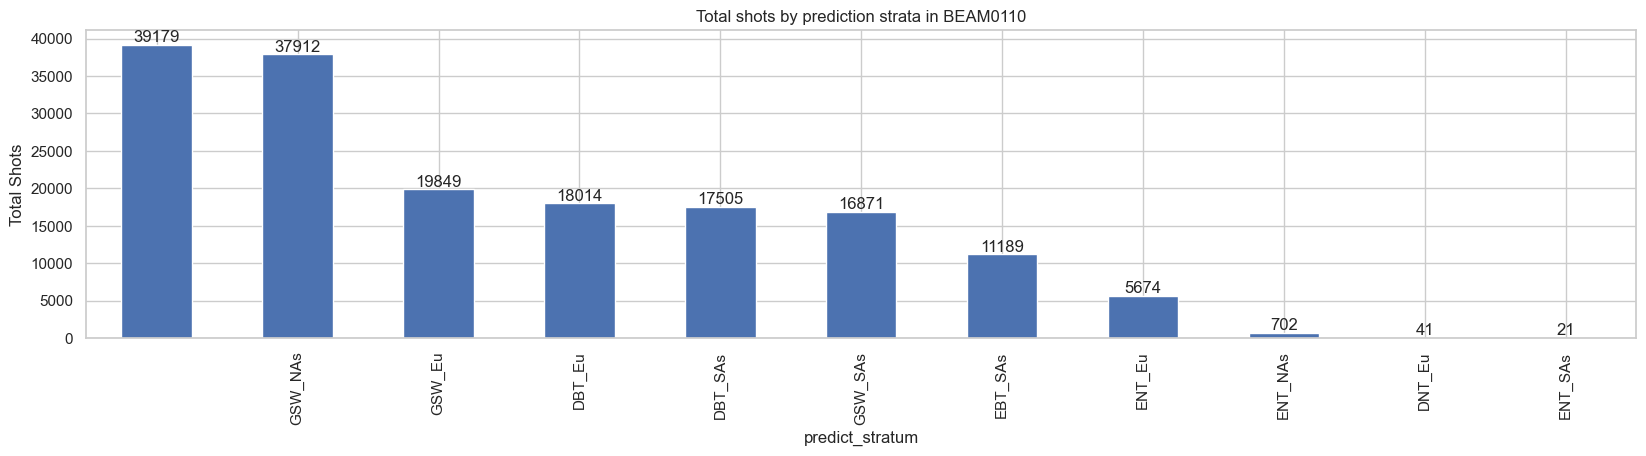

In [13]:
ax = df_l4a.predict_stratum.value_counts().plot(kind='bar',  ylabel='Total Shots', figsize=(20, 4))
ax.set_title(f'Total shots by prediction strata in {beam}')
ax.bar_label(ax.containers[0])
plt.show()

There are ten prediction strata in the `BEAM0110`. Let's also plot total shots by the selected algorithm setting groups.

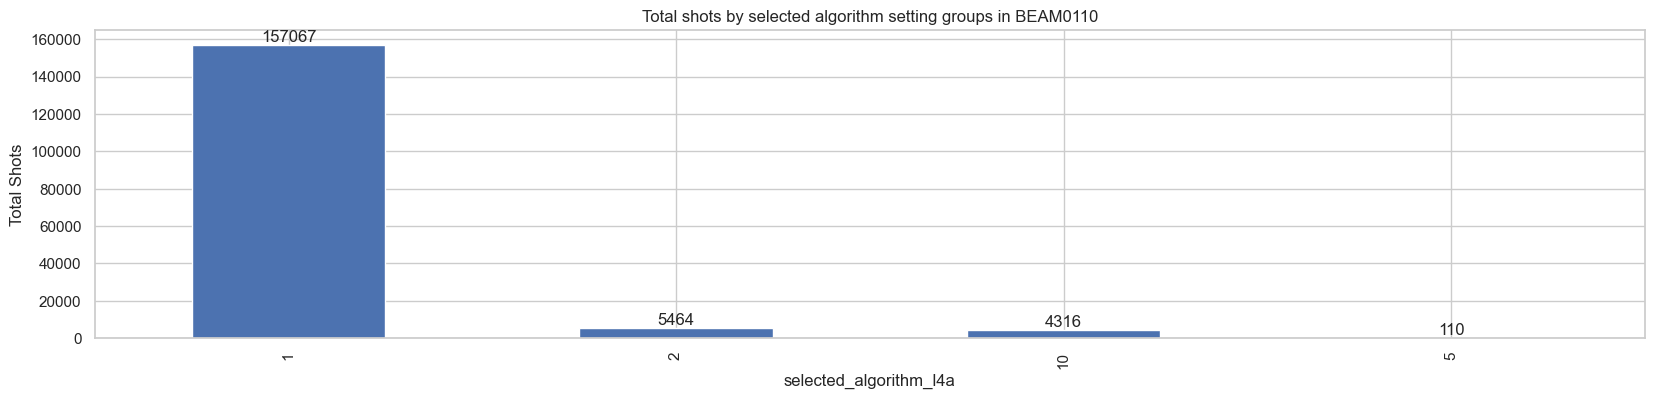

In [14]:
ax = df_l4a.selected_algorithm_l4a.value_counts().plot(kind='bar', ylabel='Total Shots', figsize=(20, 4))
ax.set_title(f'Total shots by selected algorithm setting groups in {beam}')
ax.bar_label(ax.containers[0])
plt.show()

There are four algorithm setting groups selected for the beam `BEAM0110`. Now, open the corresponding GEDI L2A file.

In [15]:
# read GEDI L2a file
hf_l2a = h5py.File(l2af[0], 'r')

shot_number_l2a = hf_l2a[beam]['shot_number'][:]
selected_algorithm_l2a = hf_l2a[beam]['selected_algorithm'][:]

# selected_algorithm for a shot may be different for L2A and L4A
# it is always advisable to get the RH metrics directly for each 
# algorithm setting groups.

rh_a1 = hf_l2a[beam]['geolocation']['rh_a1'][:]/100
rh_a2 = hf_l2a[beam]['geolocation']['rh_a2'][:]/100
rh_a3 = hf_l2a[beam]['geolocation']['rh_a3'][:]/100
rh_a4 = hf_l2a[beam]['geolocation']['rh_a4'][:]/100
rh_a5 = hf_l2a[beam]['geolocation']['rh_a5'][:]/100
rh_a6 = hf_l2a[beam]['geolocation']['rh_a6'][:]/100

# Algorithm setting group 10 indicates that agorithm setting 5 
# has been used but that the lowest detected mode in this
# algorithm is likely a noise detection and that a higher mode 
# has been subsequently used to calculate the metrics. 
# Please refer to Level 2A user guide for details
# https://lpdaac.usgs.gov/documents/998/GEDI02_UserGuide_V21.pdf
selected_mode = hf_l4a[beam]['selected_mode'][:] # using L4A selected_mode
elevs_allmodes_a5 = hf_l2a[beam]['geolocation']['elevs_allmodes_a5'][:]
elev_lowestmode_a5 = hf_l2a[beam]['geolocation']['elev_lowestmode_a5'][:]
elev_lowestmode =[]
for i in range(selected_mode.shape[0]):
    elev_lowestmode.append(elevs_allmodes_a5[i, selected_mode[i]])
elev_lowestmode = np.array(elev_lowestmode)
rh_a10 = rh_a5 - (elev_lowestmode[:, None] - elev_lowestmode_a5[:, None])

df_l2a = pd.DataFrame(list(zip(shot_number_l2a, rh_a1, rh_a2, rh_a3, rh_a4, rh_a5, rh_a6, rh_a10, 
                               selected_algorithm_l2a)), 
                     columns=['shot_number_l2a', 'rh_a1', 'rh_a2', 'rh_a3', 'rh_a4', 'rh_a5', 'rh_a6', 'rh_a10', 
                              'selected_algorithm_l2a'])
df_l2a['shot_number_l2a'] = df_l2a['shot_number_l2a'].astype(str).str[-8:]
df_l2a.set_index('shot_number_l2a', inplace=True)
df_l2a.head()

,rh_a1,rh_a2,rh_a3,rh_a4,rh_a5,rh_a6,rh_a10,selected_algorithm_l2a
shot_number_l2a,,,,,,,,
00475310,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.08, -1.04, -1.0, -0.97, -0.93, -0.89, -0.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.75, -1.68, -1.6, -1.53, -1.45, -1.38, -1.3...","[-0.33, -0.33, -0.29, -0.29, -0.26, -0.22, -0....","[-4.177726745605469, -4.1077267456054685, -4.0...",2
00475311,"[-1.19, -1.15, -1.12, -1.08, -1.04, -1.04, -1....","[-2.35, -2.27, -2.16, -2.09, -2.01, -1.94, -1....","[-1.26, -1.23, -1.19, -1.15, -1.15, -1.12, -1....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....","[-1.97, -1.94, -1.86, -1.79, -1.75, -1.68, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....",1
00475312,"[-0.97, -0.97, -0.93, -0.89, -0.85, -0.85, -0....","[-2.46, -2.39, -2.31, -2.24, -2.16, -2.09, -2....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-0.97, -0.97, -0.93, -0.93, -0.89, -0.89, -0....","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...","[-2.01, -1.97, -1.9, -1.86, -1.83, -1.75, -1.7...","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...",1
00475313,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.34, -1.3, -1.26, -1.23, -1.19, -1.15, -1.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.33, -0.29, -0.22, -0.18, -0.11, -0.03, 0.0...","[-0.18, -0.18, -0.18, -0.14, -0.14, -0.14, -0....","[-3.1685696411132813, -3.1285696411132813, -3....",2
00475314,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[158.7861328125, 158.7861328125, 158.786132812...",1


We will now join the L4A dataframe (`df_l4a`) with the L2A dataframe (`df_2a`) using [pandas' join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html).

In [16]:
df_l4a = df_l4a.join(df_l2a)
df_l4a = df_l4a[df_l4a.agbd_l4a != -9999] # removing Nan L4A agbd values
df_l4a.head()

,agbd_l4a,selected_algorithm_l4a,predict_stratum,rh_a1,rh_a2,rh_a3,rh_a4,rh_a5,rh_a6,rh_a10,selected_algorithm_l2a
shot_number_l4a,,,,,,,,,,,
00475311,25.602335,1,ENT_Eu,"[-1.19, -1.15, -1.12, -1.08, -1.04, -1.04, -1....","[-2.35, -2.27, -2.16, -2.09, -2.01, -1.94, -1....","[-1.26, -1.23, -1.19, -1.15, -1.15, -1.12, -1....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....","[-1.97, -1.94, -1.86, -1.79, -1.75, -1.68, -1....","[-2.87, -2.68, -2.53, -2.39, -2.27, -2.16, -2....",1
00475312,24.043011,1,ENT_Eu,"[-0.97, -0.97, -0.93, -0.89, -0.85, -0.85, -0....","[-2.46, -2.39, -2.31, -2.24, -2.16, -2.09, -2....","[-1.19, -1.19, -1.15, -1.12, -1.08, -1.08, -1....","[-0.97, -0.97, -0.93, -0.93, -0.89, -0.89, -0....","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...","[-2.01, -1.97, -1.9, -1.86, -1.83, -1.75, -1.7...","[-3.06, -2.95, -2.8, -2.68, -2.57, -2.46, -2.3...",1
00475317,24.283388,1,ENT_Eu,"[-1.94, -1.9, -1.83, -1.79, -1.75, -1.68, -1.6...","[-3.13, -3.02, -2.87, -2.76, -2.65, -2.57, -2....","[-2.24, -2.2, -2.12, -2.09, -2.01, -1.97, -1.9...","[-1.94, -1.9, -1.86, -1.79, -1.75, -1.71, -1.6...","[-3.54, -3.36, -3.17, -3.02, -2.87, -2.76, -2....","[-2.8, -2.72, -2.61, -2.53, -2.46, -2.35, -2.3...","[-3.54, -3.36, -3.17, -3.02, -2.87, -2.76, -2....",1
00475318,23.047647,2,ENT_Eu,"[-0.14, -0.14, -0.14, -0.11, -0.11, -0.07, -0....","[-2.2, -2.16, -2.09, -2.01, -1.97, -1.9, -1.86...","[-0.07, -0.07, -0.07, -0.03, -0.03, 0.0, 0.0, ...","[-0.14, -0.14, -0.14, -0.14, -0.14, -0.14, -0....","[-3.06, -2.95, -2.83, -2.72, -2.61, -2.5, -2.4...","[-1.56, -1.53, -1.49, -1.45, -1.38, -1.34, -1....","[-3.06, -2.95, -2.83, -2.72, -2.61, -2.5, -2.4...",2
00475320,23.937260,1,ENT_Eu,"[-0.59, -0.59, -0.56, -0.56, -0.52, -0.52, -0....","[-2.65, -2.57, -2.53, -2.46, -2.39, -2.31, -2....","[-0.85, -0.85, -0.82, -0.82, -0.78, -0.78, -0....","[-0.59, -0.59, -0.59, -0.59, -0.56, -0.56, -0....","[-3.36, -3.24, -3.13, -3.06, -2.95, -2.87, -2....","[-2.05, -2.01, -1.97, -1.9, -1.86, -1.83, -1.7...","[-3.36, -3.24, -3.13, -3.06, -2.95, -2.87, -2....",1


Let's calculate AGBD values from L2A RH metrics and save them to a new column 'agbd_l2a' in the dataframe.

In [17]:
def calculate_agbd(ps, sag, rh1, rh2, rh3, rh4, rh5, rh6, rh10):
    shot_model = df_l4a_model.loc[ps]
    agbd_t_l2a = shot_model['par'][0] # intercept
    for i in range(shot_model['npar']-1):
        r = shot_model['rh_index'][i]
        if (sag == 1):
            rh = rh1
        elif (sag == 2):
            rh = rh2
        elif (sag == 3):
            rh = rh3
        elif (sag == 4):
            rh = rh4
        elif (sag == 5):
            rh = rh5
        elif (sag == 6):
            rh = rh6
        elif (sag == 10):
            rh = rh10
            
        xvar_x = np.sqrt(rh[r] + predictor_offset)
        agbd_t_l2a += shot_model['par'][i+1] * xvar_x

    return (agbd_t_l2a**2) * shot_model['bias_correction_value']

predictor_offset = hf_l4a[beam]['agbd_prediction'].attrs['predictor_offset']
df_l4a['agbd_l2a']= df_l4a.apply(lambda x: calculate_agbd(x['predict_stratum'], x['selected_algorithm_l4a'],
                                                          x['rh_a1'], x['rh_a2'], x['rh_a3'], x['rh_a4'],
                                                          x['rh_a5'], x['rh_a6'], x['rh_a10'] ), axis=1)

# closing files
hf_l4a.close()
hf_l2a.close()

We will plot the L4A AGBD values against the AGBD derived from L2A RH metrics by the algorithm setting groups.

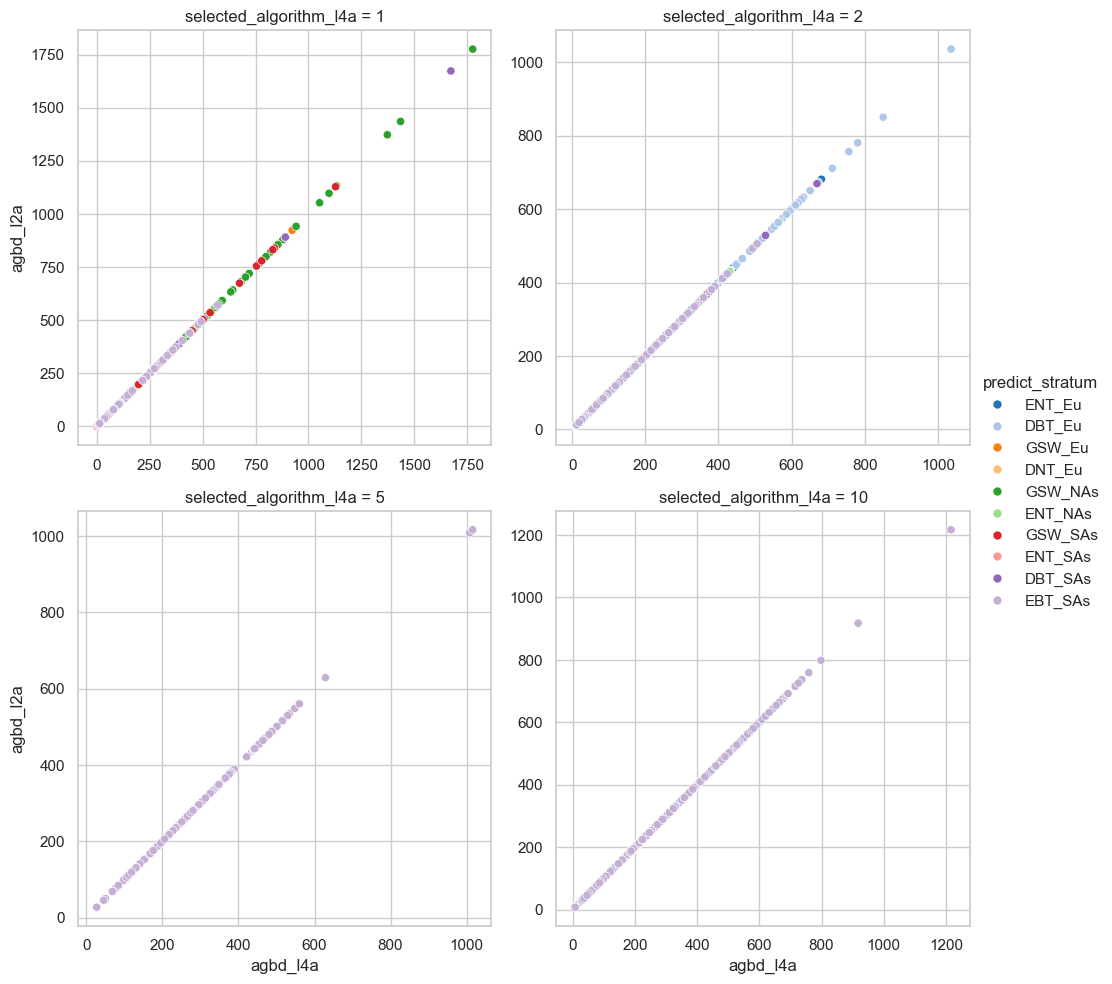

In [18]:
sns.relplot(data=df_l4a, x="agbd_l4a", y="agbd_l2a", hue="predict_stratum", 
                col="selected_algorithm_l4a", col_wrap=2,  palette="tab20", facet_kws={'sharey': False, 'sharex': False})
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)


We will plot the L4A AGBD values against the AGBD derived from L2A RH metrics by the prediction strata to check if the AGBD values look all right.

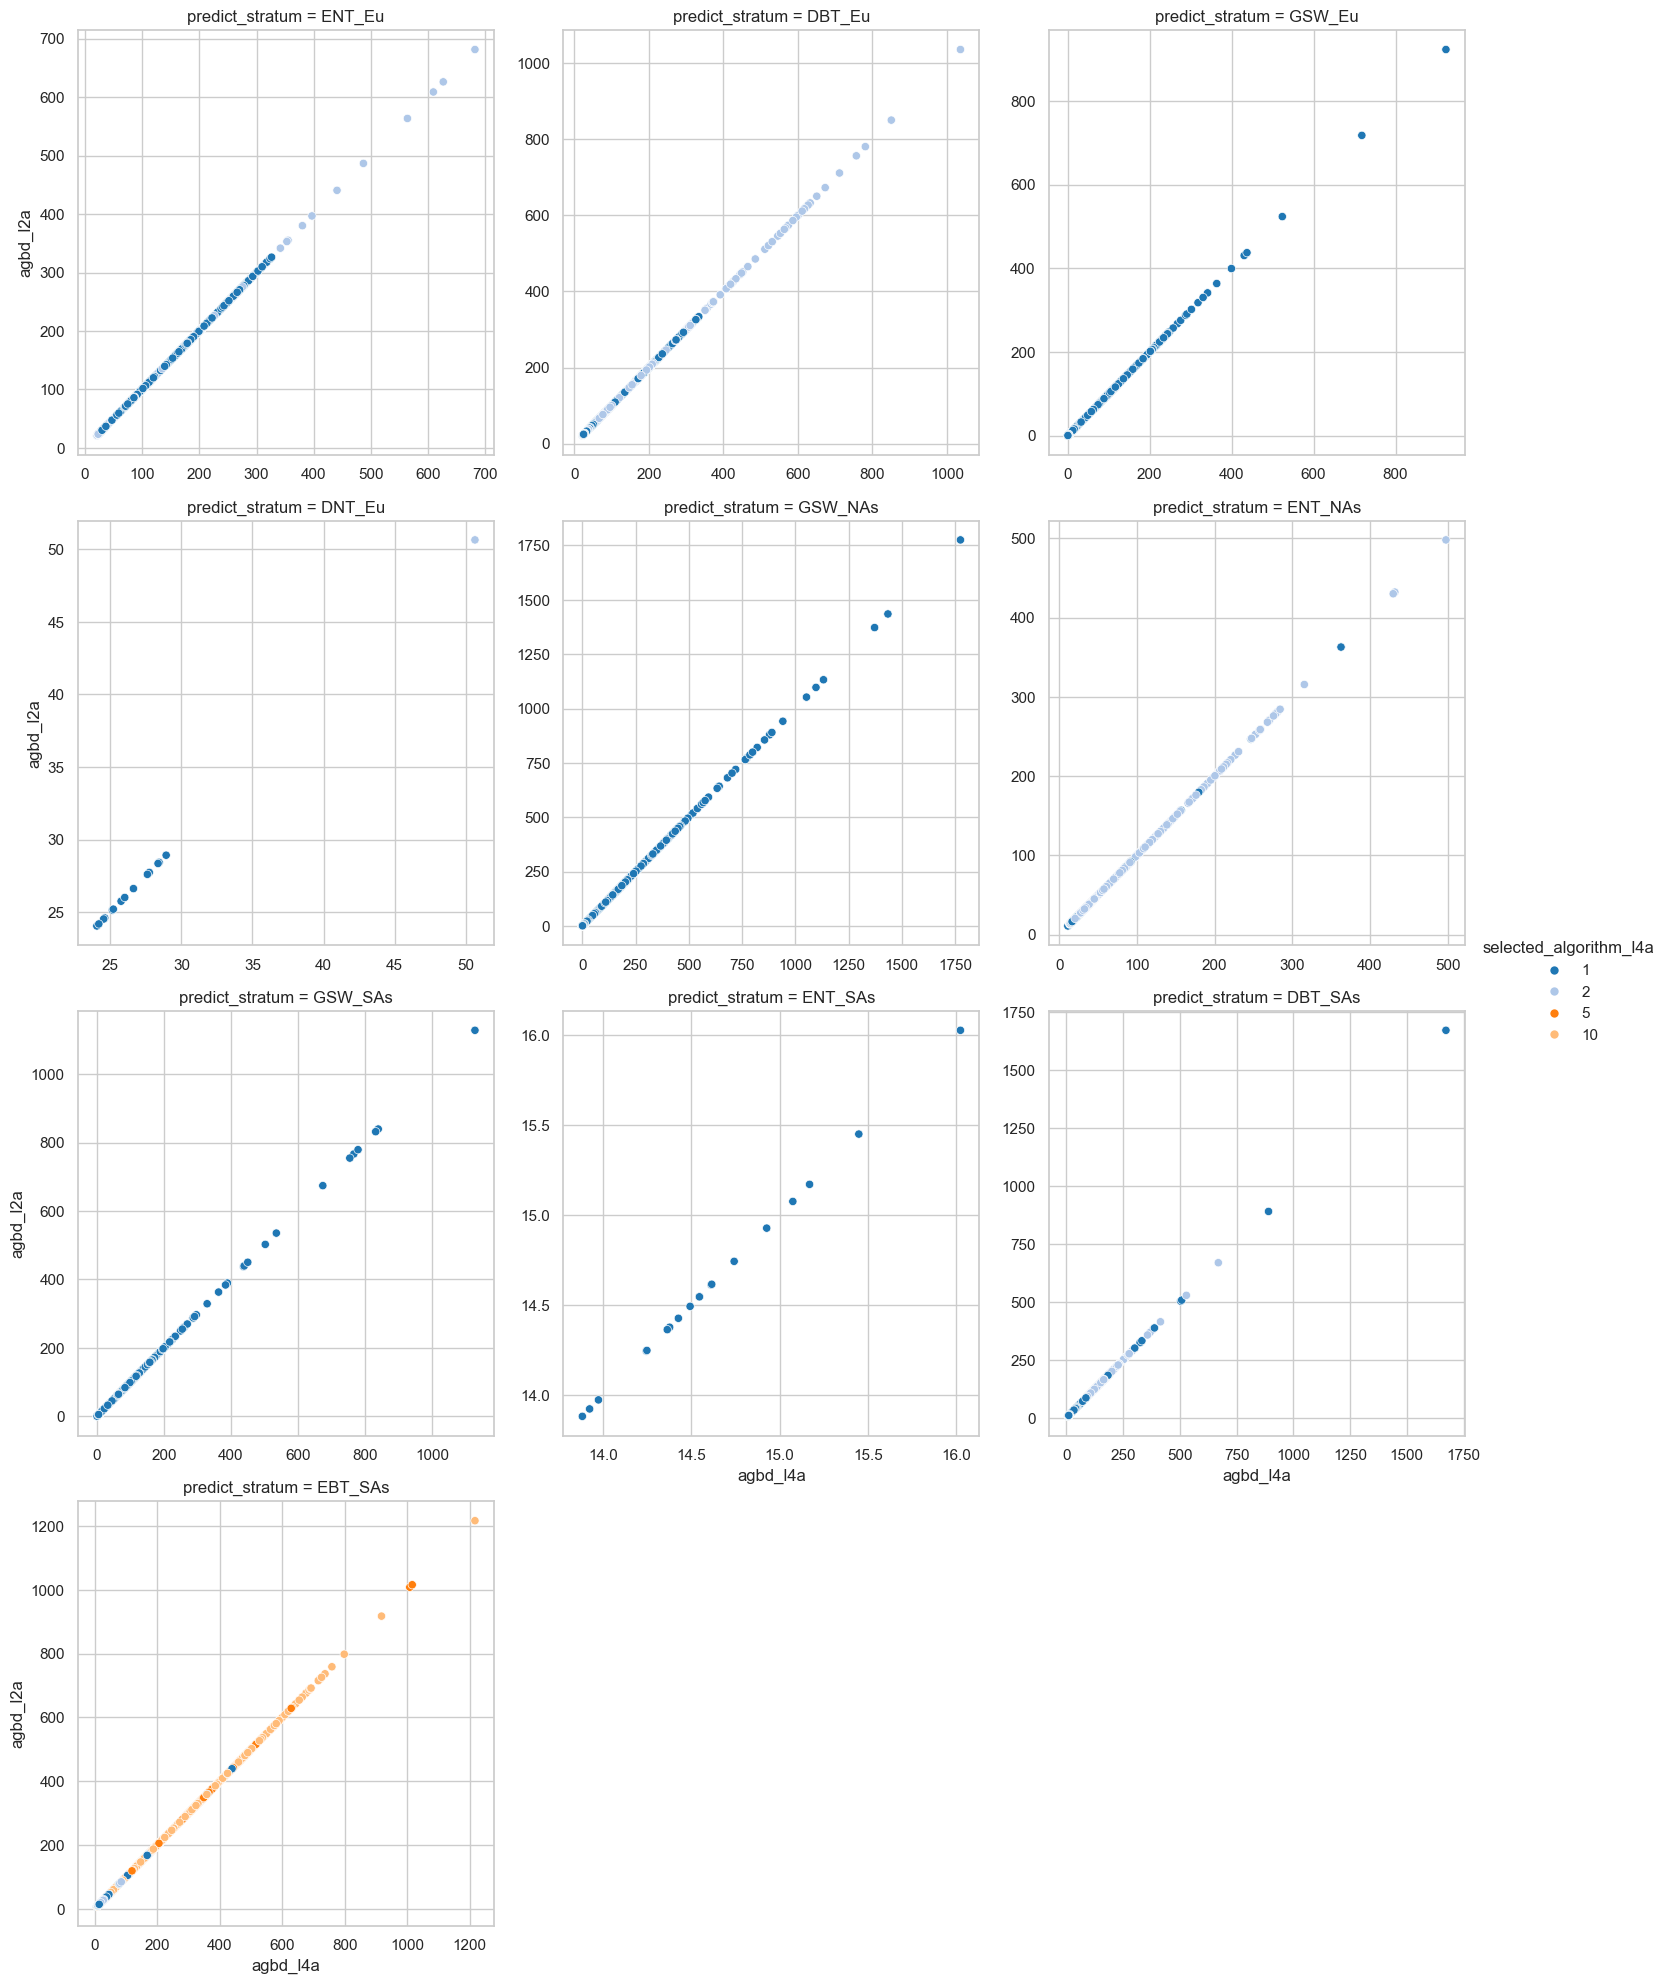

In [19]:
sns.relplot(data=df_l4a, x="agbd_l4a", y="agbd_l2a", hue="selected_algorithm_l4a", 
                col="predict_stratum", col_wrap=3, palette="tab20", facet_kws={'sharey': False, 'sharex': False})
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)

## References
```{bibliography}
:style: plain
:filter: docname in docnames
```